###          1. Importing Libraries and Dataset

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2
from tqdm.notebook import tqdm
from sklearn import metrics
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings('ignore')

###  2. Importing Dataset

In [32]:
df = pd.read_csv('parkinson_disease.csv')

In [33]:
pd.set_option('display.max_columns', 10)
df.head(5)

,id,gender,PPE,DFA,RPDE,...,tqwt_kurtosisValue_dec_33,tqwt_kurtosisValue_dec_34,tqwt_kurtosisValue_dec_35,tqwt_kurtosisValue_dec_36,class
0,0,1,0.85247,0.71826,0.57227,...,4.4625,2.6202,3.0004,18.9405,1
1,0,1,0.76686,0.69481,0.53966,...,9.5082,6.5245,6.3431,45.1780,1
2,0,1,0.85083,0.67604,0.58982,...,4.8066,2.9199,3.1495,4.7666,1
3,1,0,0.41121,0.79672,0.59257,...,4.6857,4.8460,6.2650,4.0603,1
4,1,0,0.32790,0.79782,0.53028,...,11.6891,8.2103,5.0559,6.1164,1


###  3. Data Exploration and Cleaning

In [34]:
df.shape

(756, 755)

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 756 entries, 0 to 755
Columns: 755 entries, id to class
dtypes: float64(749), int64(6)
memory usage: 4.4 MB


In [36]:
df.dtypes


id                             int64
gender                         int64
PPE                          float64
DFA                          float64
RPDE                         float64
                              ...   
tqwt_kurtosisValue_dec_33    float64
tqwt_kurtosisValue_dec_34    float64
tqwt_kurtosisValue_dec_35    float64
tqwt_kurtosisValue_dec_36    float64
class                          int64
Length: 755, dtype: object

In [37]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,756.0,125.500000,72.793721,0.000000,62.750000,125.500000,188.250000,251.00000
gender,756.0,0.515873,0.500079,0.000000,0.000000,1.000000,1.000000,1.00000
PPE,756.0,0.746284,0.169294,0.041551,0.762833,0.809655,0.834315,0.90766
DFA,756.0,0.700414,0.069718,0.543500,0.647053,0.700525,0.754985,0.85264
RPDE,756.0,0.489058,0.137442,0.154300,0.386537,0.484355,0.586515,0.87123
...,...,...,...,...,...,...,...,...
tqwt_kurtosisValue_dec_33,756.0,12.375335,16.341665,1.628700,3.114375,4.741450,12.201325,73.53220
tqwt_kurtosisValue_dec_34,756.0,14.799230,15.722502,1.861700,3.665925,6.725700,21.922050,62.00730
tqwt_kurtosisValue_dec_35,756.0,14.751559,14.432979,1.955900,3.741275,7.334250,22.495175,57.54430
tqwt_kurtosisValue_dec_36,756.0,31.481110,34.230991,2.364000,3.948750,10.637250,61.125325,156.42370


### The total number of missing values in the dataset is initially checked  If missing values are detected, a column wise analysis is then conducted to identify the affected features and understand the source of the missing data.

In [38]:
df.isnull().sum().sum()

np.int64(0)

### By grouping the dataset by patient ID, multiple observations from the same individual are aggregated into a single representative record using the mean. The ID column is removed afterward, as it does not contribute to the feature set used for model training.

In [39]:
df = df.groupby('id').mean().reset_index()
df.drop('id', axis=1, inplace=True)

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Columns: 754 entries, gender to class
dtypes: float64(754)
memory usage: 1.4 MB


### Correlation-based feature removal is a feature selection technique that eliminates redundant variables by removing one feature from pairs of features that exhibit high correlation, thereby reducing multicollinearity and improving model performance. Correlation measures how strongly two features move together: a high positive correlation (close to +1) indicates that both features increase together, a high negative correlation (close to −1) indicates that one feature increases while the other decreases, and a low correlation (close to 0) indicates little or no relationship. When two features are highly correlated, they often carry the same information. In machine learning—particularly in biomedical datasets with a large number of features—such redundancy can lead to model instability, overfitting, poor interpretability, and issues for linear models due to multicollinearity. By removing one of the correlated features, the model becomes more stable and generalizes better to unseen data.

In [41]:
corr_matrix = df.drop('class', axis=1).corr().abs()

upper = corr_matrix.where(
    np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
)

to_drop = [
    column for column in upper.columns
    if any(upper[column] > 0.7)
]

df_reduced = df.drop(columns=to_drop)
df_reduced.shape


(252, 208)

### What happened behind the scenes Initially, the dataset contained approximately 755 features, many of which were highly correlated and therefore redundant. After applying correlation-based feature removal, these redundant features were eliminated, leaving only 29 informative and non-redundant features. This confirms that the feature selection process worked correctly. Why this is a good result: With the original dataset containing roughly 756 samples and 755 features, there was a very high risk of overfitting. After feature reduction, the dataset now consists of 252 samples and 29 features, resulting in a much better feature-to-sample ratio. This reduction helps improve model generalization, reduces overfitting, enhances model stability, and improves interpretability—an especially important factor in biomedical machine learning.

In [42]:
df.columns


Index(['gender', 'PPE', 'DFA', 'RPDE', 'numPulses', 'numPeriodsPulses',
       'meanPeriodPulses', 'stdDevPeriodPulses', 'locPctJitter',
       'locAbsJitter',
       ...
       'tqwt_kurtosisValue_dec_28', 'tqwt_kurtosisValue_dec_29',
       'tqwt_kurtosisValue_dec_30', 'tqwt_kurtosisValue_dec_31',
       'tqwt_kurtosisValue_dec_32', 'tqwt_kurtosisValue_dec_33',
       'tqwt_kurtosisValue_dec_34', 'tqwt_kurtosisValue_dec_35',
       'tqwt_kurtosisValue_dec_36', 'class'],
      dtype='object', length=754)

### Given the high dimensionality of the dataset, feature reduction was performed prior to model training. The initial dataset contained approximately 755 features with only 756 samples, which poses a high risk of overfitting. Therefore, features were reduced first (e.g., selecting the top 30 most informative features), and models were trained on this cleaner feature set. This approach significantly reduces overfitting, enables faster model training, and produces more stable and interpretable results—an important requirement in biomedical applications where clinical explainability is essential.

### While some machine learning models can automatically identify important features when trained on high-dimensional data, prior feature selection was applied in this case to minimize redundancy and mitigate overfitting caused by the limited sample size. Although this approach may exclude weak but potentially useful features and requires manually choosing the number of features, it provides a better balance between performance, stability, and interpretability. This strategy was particularly appropriate for the dataset, as earlier experiments showed overfitting in complex models such as XGBoost, and the reduced feature set supports clearer explanations for medical professionals.

In [43]:
X = df.drop('class', axis=1)
X_norm = MinMaxScaler().fit_transform(X)
selector = SelectKBest(chi2, k=30)
selector.fit(X_norm, df['class'])
filtered_columns = selector.get_support()
filtered_data = X.loc[:, filtered_columns]
filtered_data['class'] = df['class']
df = filtered_data
df.shape

(252, 31)

### A pie chart was used to visualize the distribution of class labels in the dataset, revealing the proportion of Parkinson’s disease and healthy control samples and highlighting potential class imbalance.

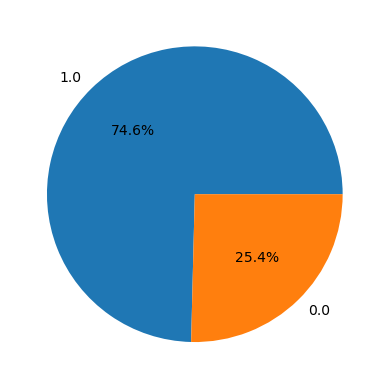

In [44]:
x = df['class'].value_counts()
plt.pie(x.values,
		labels = x.index,
		autopct='%1.1f%%')
plt.show()

### The class distribution analysis revealed an imbalanced dataset, with approximately 74.6% Parkinson’s disease cases and 25.4% healthy controls. This imbalance necessitated the use of imbalance-aware evaluation metrics and preprocessing techniques to ensure robust and unbiased model performance.

In [45]:
features = df.drop('class', axis=1)
target = df['class']


X_train, X_val, y_train, y_val = train_test_split(features, target,
                                                  test_size=0.2,
                                                  random_state=10)

ros = RandomOverSampler(sampling_strategy=1.0, random_state=0)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

X_resampled.shape, y_resampled.value_counts()

((302, 30),
 class
 1.0    151
 0.0    151
 Name: count, dtype: int64)


================ Logistic Regression ================

Training ROC-AUC: 0.8946537432568746
Validation ROC-AUC: 0.833976833976834

Confusion Matrix:
[[ 6  8]
 [ 2 35]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.75      0.43      0.55        14
         1.0       0.81      0.95      0.88        37

    accuracy                           0.80        51
   macro avg       0.78      0.69      0.71        51
weighted avg       0.80      0.80      0.78        51



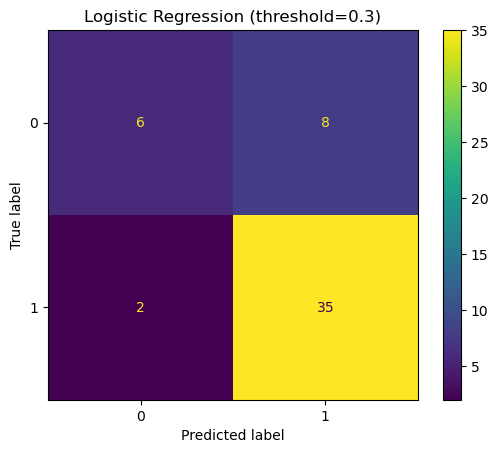


================ SVM (RBF) ================

Training ROC-AUC: 0.9201350817946581
Validation ROC-AUC: 0.7393822393822393

Confusion Matrix:
[[ 6  8]
 [ 2 35]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.75      0.43      0.55        14
         1.0       0.81      0.95      0.88        37

    accuracy                           0.80        51
   macro avg       0.78      0.69      0.71        51
weighted avg       0.80      0.80      0.78        51



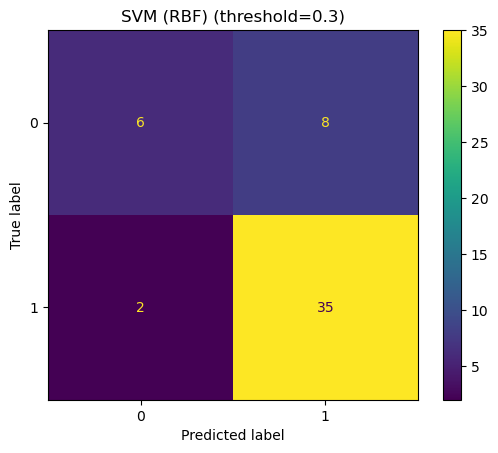


================ XGBoost ================

Training ROC-AUC: 1.0
Validation ROC-AUC: 0.7972972972972973

Confusion Matrix:
[[ 8  6]
 [ 4 33]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.67      0.57      0.62        14
         1.0       0.85      0.89      0.87        37

    accuracy                           0.80        51
   macro avg       0.76      0.73      0.74        51
weighted avg       0.80      0.80      0.80        51



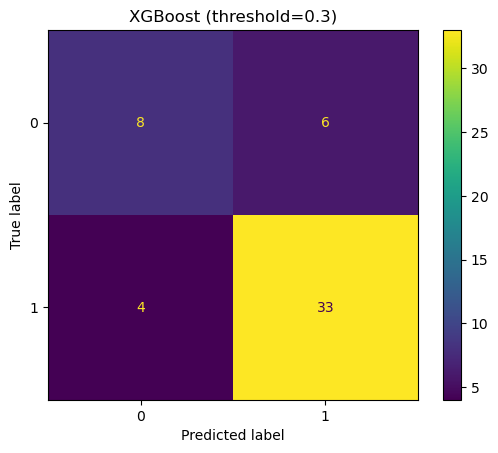

In [46]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier

from sklearn.metrics import (
    roc_auc_score,
    confusion_matrix,
    classification_report,
    ConfusionMatrixDisplay
)

# -------------------------------------------------
# 1️⃣ SCALING (fit ONLY on training data)
# -------------------------------------------------
scaler = StandardScaler()

X_resampled_scaled = scaler.fit_transform(X_resampled)
X_val_scaled = scaler.transform(X_val)

# -------------------------------------------------
# 2️⃣ MODELS
# -------------------------------------------------
models = {
    "Logistic Regression": LogisticRegression(
        penalty="l2",
        C=0.5,
        solver="liblinear",
        max_iter=1000,
        random_state=10
    ),

    "SVM (RBF)": SVC(
        kernel="rbf",
        C=1.0,
        gamma="scale",
        probability=True,
        random_state=10
    ),

    "XGBoost": XGBClassifier(
        n_estimators=100,
        max_depth=3,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric="logloss",
        random_state=10
    )
}

# -------------------------------------------------
# 3️⃣ TRAIN + EVALUATE (ROC-AUC + CONFUSION MATRIX)
# -------------------------------------------------
THRESHOLD = 0.3   # screening-focused threshold

for name, model in models.items():
    print(f"\n================ {name} ================\n")

    # Train
    model.fit(X_resampled_scaled, y_resampled)

    # Probabilities
    train_probs = model.predict_proba(X_resampled_scaled)[:, 1]
    val_probs = model.predict_proba(X_val_scaled)[:, 1]

    # ROC-AUC
    print("Training ROC-AUC:", roc_auc_score(y_resampled, train_probs))
    print("Validation ROC-AUC:", roc_auc_score(y_val, val_probs))

    # Threshold-based prediction
    y_pred = (val_probs >= THRESHOLD).astype(int)

    # Confusion Matrix
    cm = confusion_matrix(y_val, y_pred)
    print("\nConfusion Matrix:")
    print(cm)

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(y_val, y_pred))

    # Plot confusion matrix
    ConfusionMatrixDisplay(confusion_matrix=cm).plot()
    plt.title(f"{name} (threshold={THRESHOLD})")
    plt.show()


### Among the evaluated models, SVM with an RBF kernel achieved the highest sensitivity while maintaining acceptable specificity, making it the most suitable model for Parkinson’s disease screening where minimizing false negatives is critical. Although XGBoost achieved slightly higher sensitivity, its perfect training performance indicates overfitting and reduced reliability. Logistic Regression provided the most interpretable results with stable performance, making it suitable for clinical decision support.